<a href="https://colab.research.google.com/github/Ghalia671/MODULE1/blob/master/Othmane_semaine4_notebook1_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8. Réseau de Neurones récurrents Long Short-Term Memory (LSTM) en  PyTorch

### D'un réseau de neurones récurrents à un LSTM
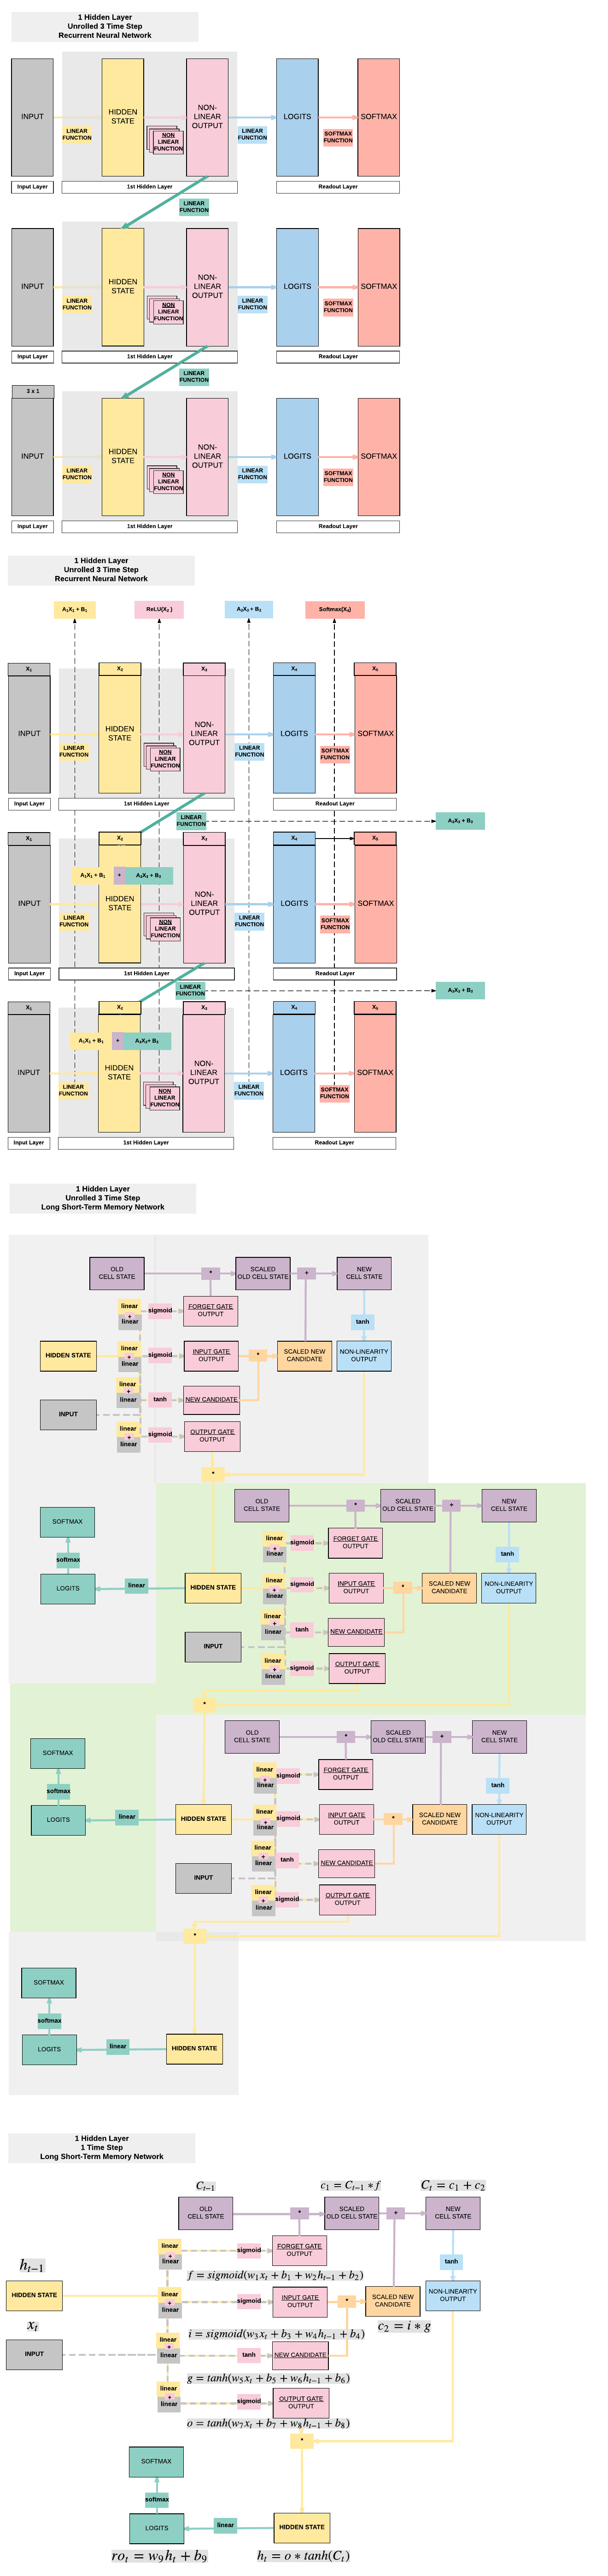



## Construire un LSTM en PyTorch

### Model A: 1 Hidden Layer
- 28 time steps
    - Chaque time step est de taille: 28 x 1
- 1 couche cachée layer

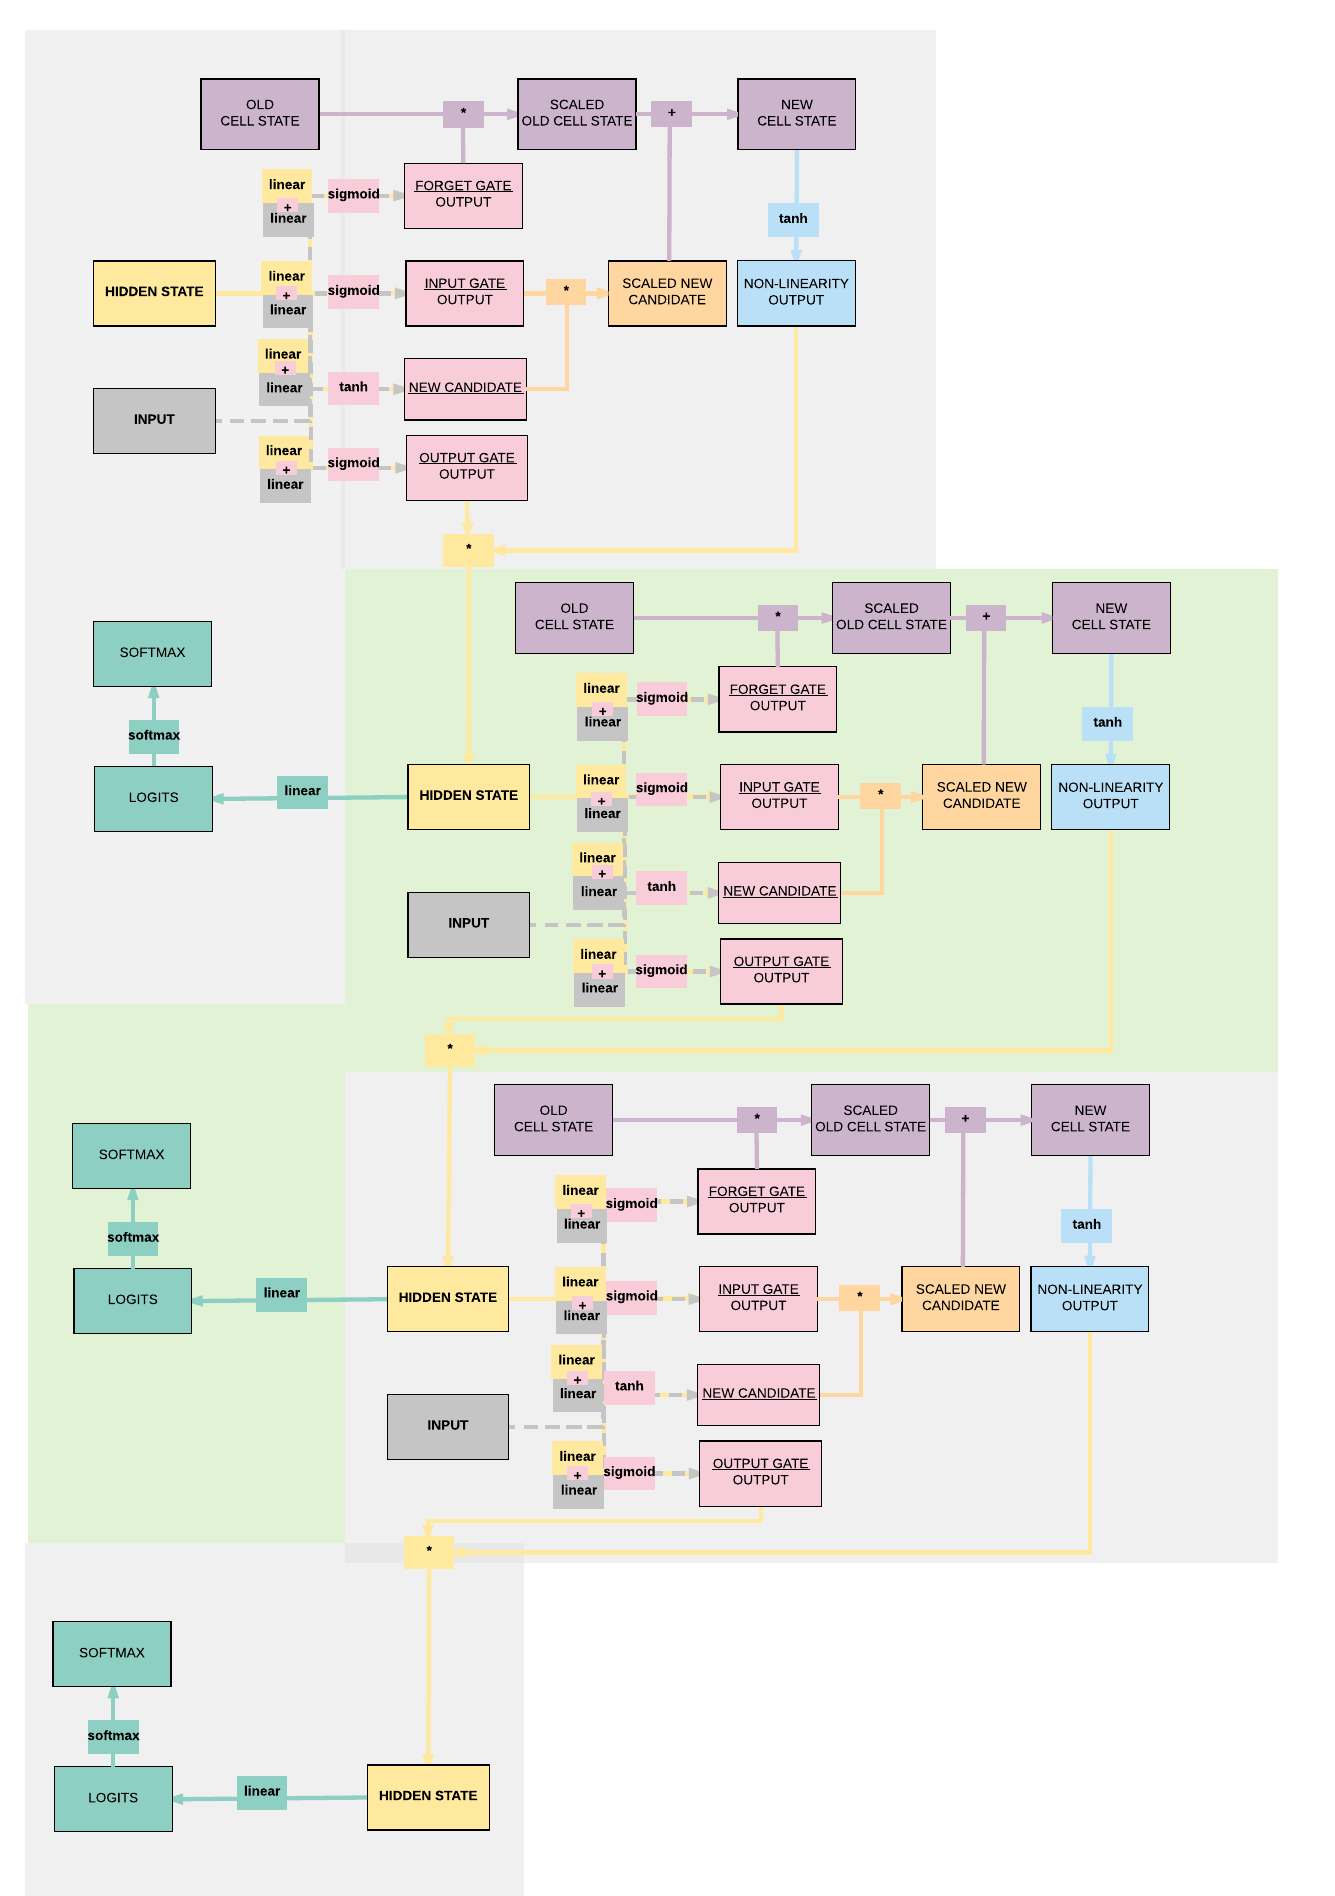

### Etapes
- Etape 1: Charger les données (entraînement et test)
- Etape 2: Rendre les données iterables
- Etape 3: Créer la classe du modèle
- Etape 4: Instancier la classe du modèle
- Etape 5: Instancier la loss classe
- Etape 6: Instancier la classe de l'optimizer
- Etape 7: Entrainer le modèle

### Etape 1: Charger les données MNIST (entraînement et test)
**Images de 1 à 9**

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [ ]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [ ]:
print(train_dataset.train_data.size())

torch.Size([60000, 28, 28])


In [ ]:
print(train_dataset.train_labels.size())

torch.Size([60000])


In [ ]:
print(test_dataset.test_data.size())

torch.Size([10000, 28, 28])


In [ ]:
print(test_dataset.test_labels.size())

torch.Size([10000])


### Etape 2: Rendre les données iterables

In [ ]:
batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### Etape 3: Créer la classe du modèle

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Dimension cachée
        self.hidden_dim = hidden_dim
        
        # Nombre de couches cachées
        self.layer_dim = layer_dim
        
        # Construction du LSTM
        # batch_first=True pour que l'input/output des tensors soient de taille
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Couche de sortie
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initilisation de l'état caché à 0
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # Initilisation de l'état de la cellule
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        
        # 28 time steps
        out, (hn, cn) = self.lstm(x, (h0,c0))
        
        # Indexer l'état caché de la dernière étape
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

### Etape 4: Instancier la classe du modèle
- 28 time steps
    - Chaque time step a pour dimension d'entrée 28
- 1 couche cachée
- Chiffre de 1-9 en entrée $\rightarrow$ dimension de sortie = 10

In [ ]:
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

In [ ]:
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

### Etape 5: Instancier la loss classe
- Long Short-Term Memory Neural Network: **Cross Entropy Loss** (loss similaire aux réseaux de neurones à convolution)    

In [ ]:
criterion = nn.CrossEntropyLoss()

### Etape 6: Instancier la classe de l'optimizer
- Equation simplifié:
    - $\theta = \theta - \eta \cdot \nabla_\theta $
        - $\theta$: paramètres (Pytorch tensors avec gradients cumulés)
        - $\eta$: taux/vitesse d'apprentissage (learning rate)
        - $\nabla_\theta$: gradients calculés
- Equation encore plus simple
    - `parametres = parametres - taux_apprentissage * parametres_gradients`
    - **A chaque itération, on met à jour les paramètres modèle**

In [ ]:
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

### Paramètres du modèle

In [ ]:
len(list(model.parameters()))

6

In [ ]:
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

torch.Size([400, 28])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([10, 100])
torch.Size([10])


#### Paramètres
- **Input** $\rightarrow$ **Gates**
    - $[400, 28] \rightarrow w_1, w_3, w_5, w_7$
    - $[400] \rightarrow b_1, b_3, b_5, b_7$
- **Hidden State** $\rightarrow$ **Gates**
    - $[400,100] \rightarrow w_2, w_4, w_6, w_8$
    - $[400] \rightarrow b_2, b_4, b_6, b_8$
- **Hidden State** $\rightarrow$ **Output**
    - $[10, 100] \rightarrow w_9 $
    - $[10] \rightarrow b_9$

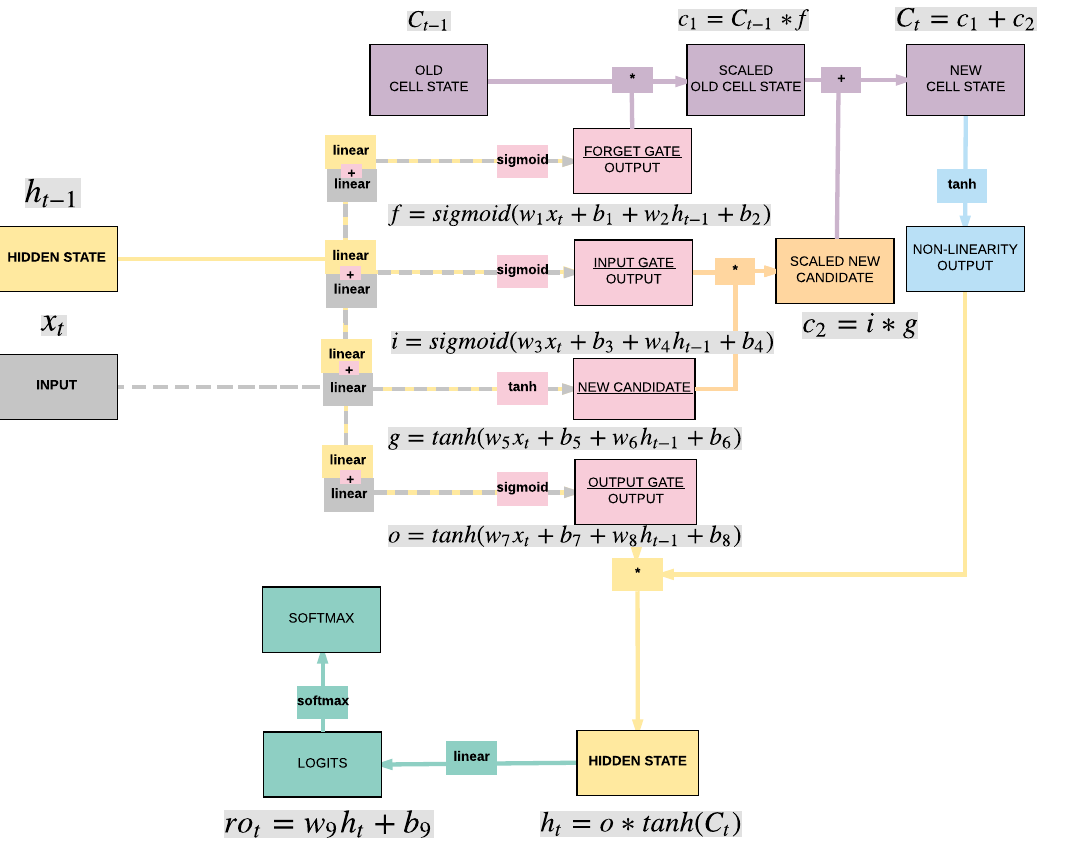

### Etape 7: Entrainer le modèle
- Process 
    1. **Convertir les données d'entrée/labels en tensors (avec possibilité d'accumuler des gradients)**
        - LSTM Input: (1, 28)
        - RNN Input: (1, 28)
        - CNN Input: (1, 28, 28) 
        - FNN Input: (1, 28*28)
    2. Nettoyer les gradients
    3. Recupérer les outputs des inputs associés 
    4. Calcul de la loss
    5. Calcul des gradients en fonction des paramètres
    6. Mettre à jour les paramètres en fonction des gradients calculés
        - `parameters = parameters - learning_rate * parameters_gradients`
    7. REPETER

In [ ]:
# Steps to unroll
seq_dim = 28  

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Charger les images en variable torch avec accumulation de gradient
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        # Nettoyer les gradients
        optimizer.zero_grad()
        
        # Forward pass pour calculer l'output 
        # outputs.size() --> 100, 10
        outputs = model(images)
        
        # Calcul de la loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Calcul de gradients en fonction des paramètres
        loss.backward()
        
        # Mise à jour des paramètres
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculer la précision (Accuracy)         
            correct = 0
            total = 0
            # Itérer sur le dataset de test
            for images, labels in test_loader:
                # Charger les images en variable torch avec accumulation de gradient
                images = images.view(-1, seq_dim, input_dim).requires_grad_()
                
                # Forward pass pour calculer les logits/output
                outputs = model(images)
                
                # Recupérer les prédictions depuis la valeur maximum
                _, predicted = torch.max(outputs.data, 1)
                
                # Nombre total de labels
                total += labels.size(0)
                
                # Total des prédictions correctes
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Afficher la loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2679243087768555. Accuracy: 16
Iteration: 1000. Loss: 1.0759284496307373. Accuracy: 65
Iteration: 1500. Loss: 0.5567511320114136. Accuracy: 84
Iteration: 2000. Loss: 0.29917922616004944. Accuracy: 90
Iteration: 2500. Loss: 0.1697448492050171. Accuracy: 94
Iteration: 3000. Loss: 0.10998506844043732. Accuracy: 95


# Résumé

- Moyens d'augementer la performance du modèle
    - Augmenter le nombre de **hidden units**
    - Augmenter le nombre de **hidden layers**
    
- **Inconvénients** 
    - Nécessite plus de **données**
    - N'augmente pas forcément **l'accuracy**

- Passage du code au **GPU**
    - Modifications au niveau du:
        - **model**
        - **tensors avec accumulation de gradients**
    - **Etapes 3, 4 and 7**

- **7 Etapes** pour la construction du modèle
    - Etape 1: Charger les données (entraînement et test)
    - Etape 2: Rendre les données iterables
    - **Etape 3: Créer la classe du modèle**
    - **Etape 4: Instancier la classe du modèle**
    - Etape 5: Instancier la loss classe
    - Etape 6: Instancier la classe de l'optimizer
    - **Etape 7: Entrainer le modèle**
